# Imports

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd 
import random 
import torch
import torchvision
from torchvision import transforms
from torch.utils.data import DataLoader,random_split
from torch import nn
import torch.nn.functional as F
import torch.optim as optim

# Data Download

In [2]:
data_dir = '~/.pytorch/digit_MNIST_data/'

train_dataset = torchvision.datasets.MNIST(data_dir, train=True, download=True)
test_dataset = torchvision.datasets.MNIST(data_dir, train=False, download=True)

# Preparation of Train/Test sets and Data Loader

In [3]:
train_transform = transforms.Compose([
    transforms.ToTensor(),
])

test_transform = transforms.Compose([
    transforms.ToTensor(),
])

train_dataset.transform = train_transform
test_dataset.transform = test_transform

m = len(train_dataset)

train_data, val_data = random_split(train_dataset, [int(m-m*0.2), int(m*0.2)])

BATCH_SIZE = 256

train_loader = torch.utils.data.DataLoader(train_data, batch_size=BATCH_SIZE)
valid_loader = torch.utils.data.DataLoader(val_data, batch_size=BATCH_SIZE)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=True)

# Definition of Convolutional Autoencoder

In [4]:
class Encoder(nn.Module):
    
    def __init__(self, encoded_space_dim, fc2_input_dim):
        super().__init__()
        
        # Convolutional section
        self.encoder_cnn = nn.Sequential(
            nn.Conv2d(1, 8, 3, stride=2, padding=1),
            nn.ReLU(True),
            nn.Conv2d(8, 16, 3, stride=2, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(True),
            nn.Conv2d(16, 32, 3, stride=2, padding=0),
            nn.ReLU(True)
        )
        
        # Flatten layer
        self.flatten = nn.Flatten(start_dim=1)
        
        # Linear section
        self.encoder_lin = nn.Sequential(
            nn.Linear(3*3*32, fc2_input_dim),
            nn.ReLU(True),
            nn.Linear(fc2_input_dim, encoded_space_dim)
        )
        
    def forward(self, x):
        x = self.encoder_cnn(x)
        x = self.flatten(x)
        x = self.encoder_lin(x)
        return x

In [5]:
class Decoder(nn.Module):
    
    def __init__(self, encoded_space_dim, fc2_input_dim):
        super().__init__()
        self.decoder_lin = nn.Sequential(
            nn.Linear(encoded_space_dim, fc2_input_dim),
            nn.ReLU(True),
            nn.Linear(fc2_input_dim, 3*3*32),
            nn.ReLU(True)
        )
        
        self.unflatten = nn.Unflatten(dim=1, unflattened_size=(32, 3, 3))
        
        self.decoder_conv = nn.Sequential(
            nn.ConvTranspose2d(32, 16, 3, stride=2, output_padding=0),
            nn.BatchNorm2d(16),
            nn.ReLU(True),
            nn.ConvTranspose2d(16, 8, 3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(8),
            nn.ReLU(True),
            nn.ConvTranspose2d(8, 1, 3, stride=2, padding=1, output_padding=1)
        )
        
    def forward(self, x):
        x = self.decoder_lin(x)
        x = self.unflatten(x)
        x = self.decoder_conv(x)
        x = torch.sigmoid(x)
        return x

# Initialization of Loss Functions and Optimizer

In [6]:
# Define the loss function
loss_fn = torch.nn.MSELoss()

# Define an optimizer (both for the encoder and the decoder!)
lr = 0.001

# Set the random seed for reproducible results
torch.manual_seed(0)

# Initialize the two networks
d = 4

encoder = Encoder(encoded_space_dim=d, fc2_input_dim=128)
decoder = Decoder(encoded_space_dim=d, fc2_input_dim=128)
params_to_optimize = [
    {'params': encoder.parameters()},
    {'params': decoder.parameters()}
]

optim = torch.optim.Adam(params_to_optimize, lr=lr, weight_decay=1e-05)

# Check if the GPU is available
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(f'Selected device: {device}')

# Move both the encoder and the decoder to the selected device
encoder.to(device)
decoder.to(device)

Selected device: cuda


Decoder(
  (decoder_lin): Sequential(
    (0): Linear(in_features=4, out_features=128, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=128, out_features=288, bias=True)
    (3): ReLU(inplace=True)
  )
  (unflatten): Unflatten(dim=1, unflattened_size=(32, 3, 3))
  (decoder_conv): Sequential(
    (0): ConvTranspose2d(32, 16, kernel_size=(3, 3), stride=(2, 2))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(16, 8, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
    (4): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(8, 1, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
  )
)

# Function for Noise Addition

In [7]:
def add_noise(inputs, noise_factor=0.3):
    noisy = inputs + torch.randn_like(inputs) * noise_factor
    noisy = torch.clip(noisy, 0., 1.)
    return noisy

# Train and Evaluation of Model

In [8]:
# Training function
def train_epoch_den(encoder, decoder, device, dataloader, loss_fn, optimizer, noise_factor=0.3, verbose=False):
    # Set train mode for both the encoder and the decoder
    encoder.train()
    decoder.train()
    train_loss = []
    # Iterate the dataloader (we do not need the label values, this is unsupervised learning)
    for image_batch, _ in dataloader: # with "_" we just ignore the labels (the second element of the dataloader tuple)

        image_noisy = add_noise(image_batch, noise_factor)
        
        # Move tensor to the proper device
        image_batch = image_batch.to(device)
        image_noisy = image_noisy.to(device)
        
        # Encode data
        encoded_data = encoder(image_noisy)
        # Decode data
        decoded_data = decoder(encoded_data)
        # Evaluate loss
        loss = loss_fn(decoded_data, image_batch)
        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        # Print batch loss
        if verbose == True:
            print('\t partial train loss (single batch): %f' % (loss.data))
        train_loss.append(loss.detach().cpu().numpy())

    return np.mean(train_loss)

In [9]:
# Testing function
def test_epoch_den(encoder, decoder, device, dataloader, loss_fn, noise_factor=0.3):
    # Set evaluation mode for encoder and decoder
    encoder.eval()
    decoder.eval()
    with torch.no_grad(): # No need to track the gradients
        # Define the lists to store the outputs for each batch
        conc_out = []
        conc_label = []
        for image_batch, _ in dataloader:
            
            image_noisy = add_noise(image_batch, noise_factor)
            
            # Move tensor to the proper device
            image_noisy = image_noisy.to(device)
            # Encode data
            encoded_data = encoder(image_noisy)
            # Decode data
            decoded_data = decoder(encoded_data)
            # Append the network output and the original image to the lists
            conc_out.append(decoded_data.cpu())
            conc_label.append(image_batch.cpu())
        # Create a single tensor with all the values in the lists
        conc_out = torch.cat(conc_out)
        conc_label = torch.cat(conc_label) 
        # Evaluate global loss
        val_loss = loss_fn(conc_out, conc_label)
    return val_loss.data

In [10]:
def plot_ae_outputs_den(encoder, decoder, n=10, noise_factor=0.3):
    plt.figure(figsize=(16, 4.5))
    targets = test_dataset.targets.numpy()
    t_idx = {i: np.where(targets==i)[0][0] for i in range(n)}
    
    for i in range(n):
        ax = plt.subplot(3, n, i+1)
        img = test_dataset[t_idx[i]][0].unsqueeze(0)
        image_noisy = add_noise(img, noise_factor)
        image_noisy = image_noisy.to(device)
        
        encoder.eval()
        decoder.eval()
        
        with torch.no_grad():
            rec_img = decoder(encoder(image_noisy))
            
        plt.imshow(img.cpu().squeeze().numpy(), cmap='gist_gray')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        
        if i == n//2:    # To have the title at the center
            ax.set_title('Original images')

        ax = plt.subplot(3, n, i + 1 + n)
        plt.imshow(image_noisy.cpu().squeeze().numpy(), cmap='gist_gray')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)  
        if i == n//2:
            ax.set_title('Corrupted images')

        ax = plt.subplot(3, n, i + 1 + n + n)
        plt.imshow(rec_img.cpu().squeeze().numpy(), cmap='gist_gray')  
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)  
        if i == n//2:
            ax.set_title('Reconstructed images')
            
        plt.subplots_adjust(left=0.1, bottom=0.1, right=0.7, top=0.9, wspace=0.3, hspace=0.3)
    plt.show()


 EPOCH 1/30 	 train loss 0.1230190172791481 	 val loss 0.06602916866540909


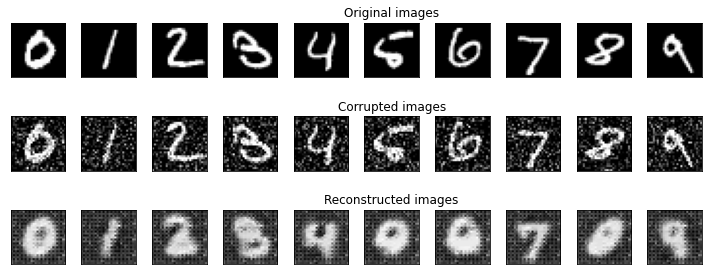


 EPOCH 5/30 	 train loss 0.03296683728694916 	 val loss 0.032452575862407684


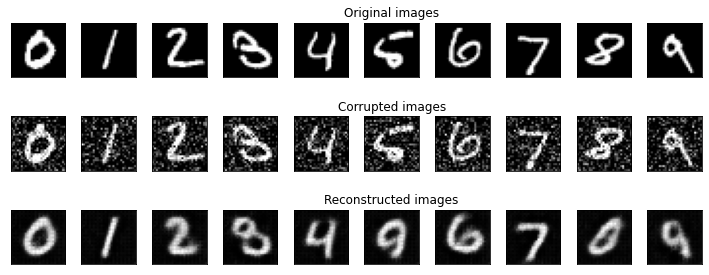


 EPOCH 10/30 	 train loss 0.02932722494006157 	 val loss 0.029434682801365852


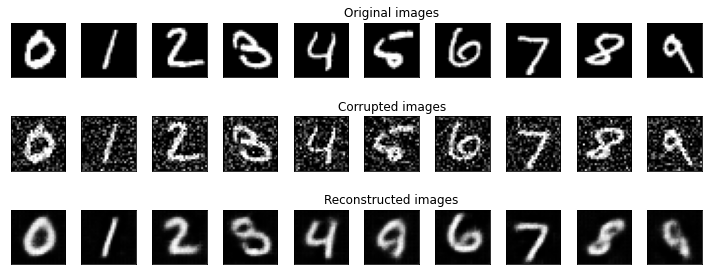


 EPOCH 15/30 	 train loss 0.028079809620976448 	 val loss 0.028207072988152504


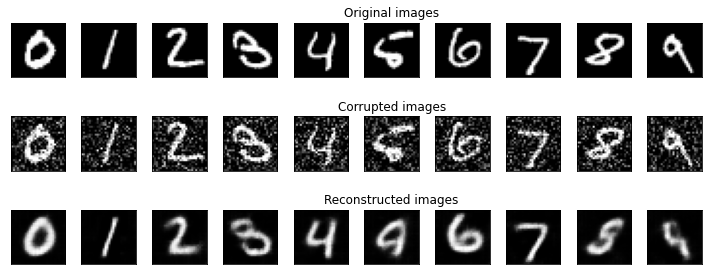


 EPOCH 20/30 	 train loss 0.027382178232073784 	 val loss 0.027511507272720337


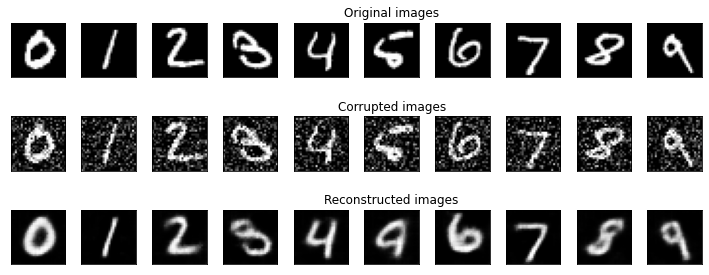


 EPOCH 25/30 	 train loss 0.02688474766910076 	 val loss 0.02712407149374485


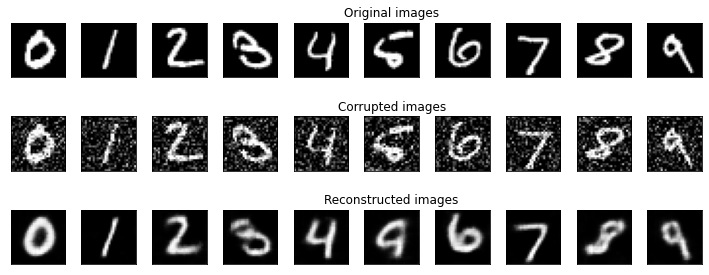


 EPOCH 30/30 	 train loss 0.026552392169833183 	 val loss 0.02688378468155861


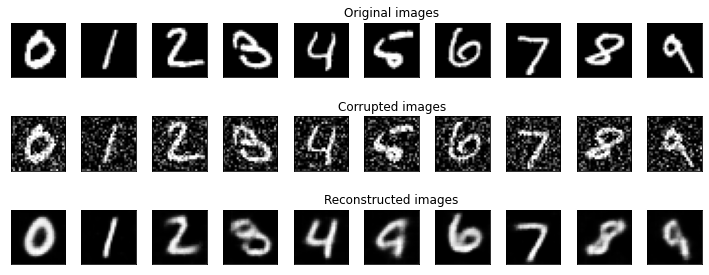

In [11]:
num_epochs = 30
noise_factor = 0.3
history_da = {'train_loss': [], 'val_loss': []}

for epoch in range(num_epochs):
    
    # Training
    train_loss = train_epoch_den(encoder, decoder, device, train_loader, loss_fn, optim, noise_factor)
    
    # Validation
    val_loss = test_epoch_den(encoder, decoder, device, test_loader, loss_fn, noise_factor)
    
    history_da['train_loss'].append(train_loss)
    history_da['val_loss'].append(val_loss)
    
    if epoch == 0 or ((epoch+1) % 5 == 0):
        print(f'\n EPOCH {epoch + 1}/{num_epochs} \t train loss {train_loss} \t val loss {val_loss}')
        plot_ae_outputs_den(encoder, decoder, n=10, noise_factor=noise_factor)

In [12]:
test_epoch_den(encoder, decoder, device, test_loader, loss_fn, noise_factor).item()

0.026928817853331566

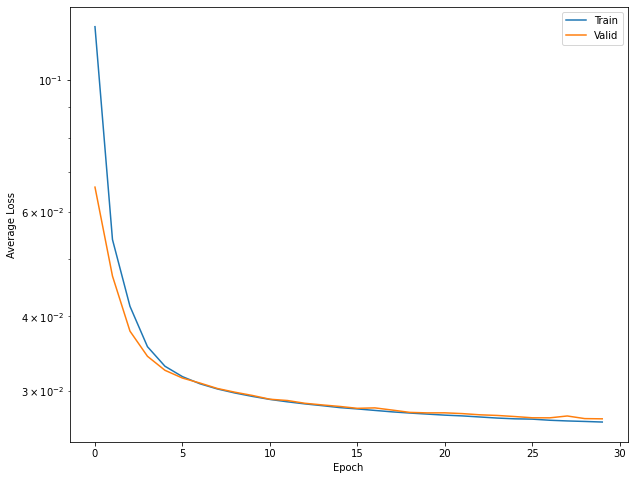

In [13]:
# Plot losses
plt.figure(figsize=(10,8))
plt.semilogy(history_da['train_loss'], label='Train')
plt.semilogy(history_da['val_loss'], label='Valid')
plt.xlabel('Epoch')
plt.ylabel('Average Loss')
#plt.grid()
plt.legend()
#plt.title('loss')
plt.show()

# Generation of New Samples from the Random Latent Code

In [14]:
# A function that shows image

def show_image(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

tensor([-0.1745,  0.0239,  0.1692, -0.0685])
tensor([0.5683, 0.6948, 0.6638, 0.6530])


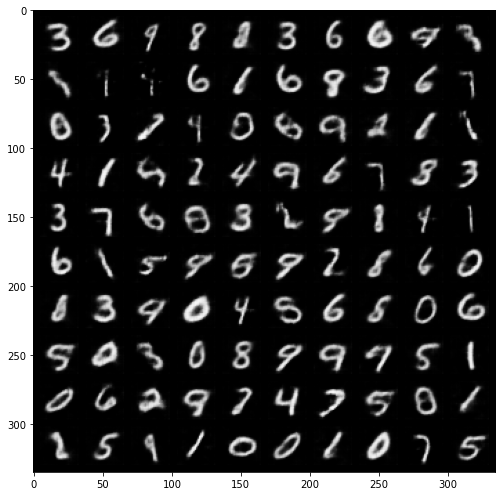

In [15]:
encoder.eval()
decoder.eval()

with torch.no_grad():
    # calculate mean and std of latent code, generated takining in test images as inputs 
    images, labels = iter(test_loader).next()
    images = images.to(device)
    latent = encoder(images)
    latent = latent.cpu()

    mean = latent.mean(dim=0)
    print(mean)
    std = (latent - mean).pow(2).mean(dim=0).sqrt()
    print(std)

    # sample latent vectors from the normal distribution
    latent = torch.randn(128, d)*std + mean

    # reconstruct images from the random latent vectors
    latent = latent.to(device)
    img_recon = decoder(latent)
    img_recon = img_recon.cpu()

    fig, ax = plt.subplots(figsize=(20, 8.5))
    show_image(torchvision.utils.make_grid(img_recon[:100], 10, 5))
    plt.show()

# Visualization of Latent Space with t-SNE

In [16]:
encoded_samples = []
for sample in test_dataset:
    img = sample[0].unsqueeze(0).to(device)
    label = sample[1]
    # Encode image
    encoder.eval()
    with torch.no_grad():
        encoded_img = encoder(img)
    # Append to list
    encoded_img = encoded_img.flatten().cpu().numpy()
    encoded_sample = {f"Enc. Variable {i}": enc for i, enc in enumerate(encoded_img)}
    encoded_sample['label'] = label
    encoded_samples.append(encoded_sample)
encoded_samples = pd.DataFrame(encoded_samples)
encoded_samples

Enc. Variable 0  Enc. Variable 1  Enc. Variable 2  Enc. Variable 3  \
0           -0.657081         1.166977        -1.086282         0.344373   
1           -0.101584         0.567531         1.709023        -0.174364   
2           -0.808817         1.226308         0.544898        -0.468091   
3            0.257397        -0.960370         0.467296        -0.028288   
4           -0.610661        -0.425412        -0.446778        -0.819080   
...               ...              ...              ...              ...   
9995         0.295455        -0.169174         1.558172         0.164327   
9996         0.948977         0.479618         0.286268         0.780303   
9997        -1.186701         0.015670        -0.247668        -0.841668   
9998        -1.047230        -0.768064         0.200614         0.778699   
9999        -0.203182        -0.864164         0.317179        -0.442185   

      label  
0         7  
1         2  
2         1  
3         0  
4         4  
...     ...  
9995      2  
9996      3  
9997      4  
9998      5  
9999      6  

[10000 rows x 5 columns]

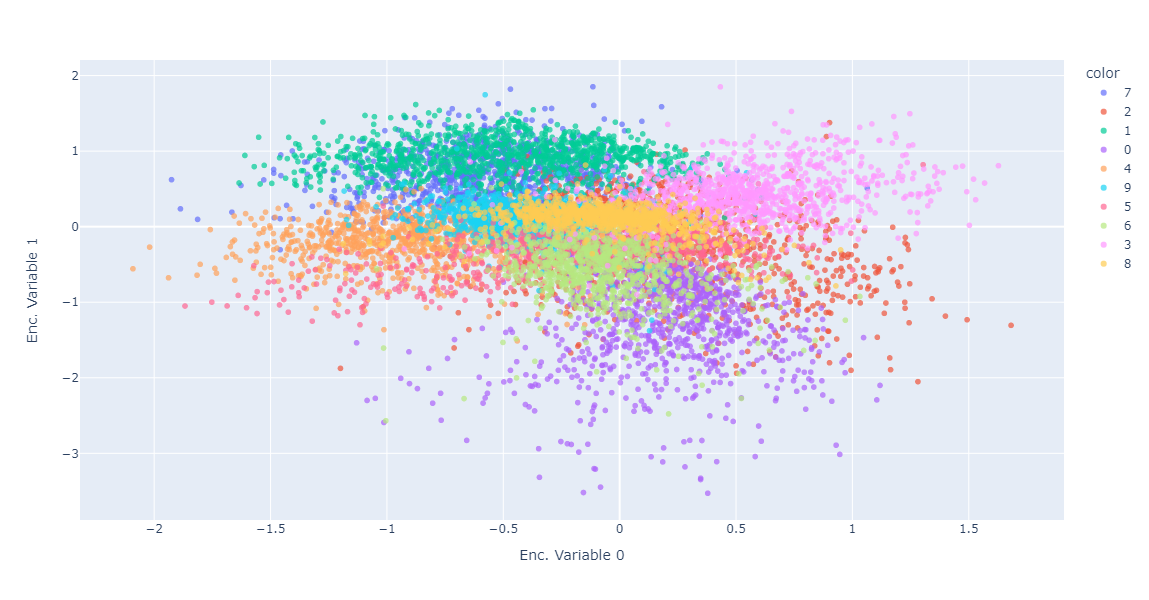

In [17]:
import plotly.express as px

px.scatter(encoded_samples, x='Enc. Variable 0', y='Enc. Variable 1', 
           color=encoded_samples.label.astype(str), opacity=0.7,
           width=800, height=600)

C:\Users\johnw\miniconda3\envs\575\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning:

The default initialization in TSNE will change from 'random' to 'pca' in 1.2.

C:\Users\johnw\miniconda3\envs\575\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning:

The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.



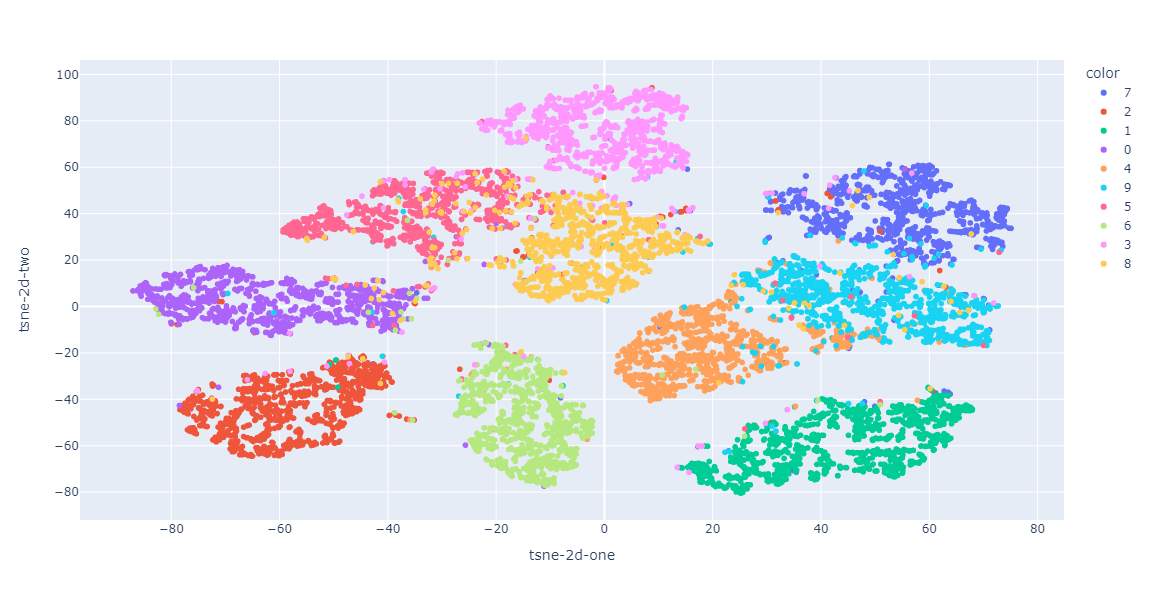

In [18]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2)
tsne_results = tsne.fit_transform(encoded_samples.drop(['label'], axis=1))
fig = px.scatter(tsne_results, x=0, y=1,
                 color=encoded_samples.label.astype(str),
                 labels={'0': 'tsne-2d-one', '1': 'tsne-2d-two'},
                 width=800, height=600)
fig.show()